# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import glob 
import pickle

## Camera Calibration using Chessboard Images

In [2]:
def camera_cal(nx=9, ny=6):
    
    # load chessboard images for calibration
    images = glob.glob('camera_cal/cal*.jpg')

    # Arrays to store object points and image points from images
    objpoints = [] # 3d points in real world space.
    imgpoints = [] # 2d points in image plane.

    # Prepare object points
    objp = np.zeros((6*9, 3), np.float32)
    objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

    # Find chessboard corners
    for image in images[:-1]:

        # Load image
        img = mpimg.imread(image)

        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Find chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

        # If found, add object points and image points
        if ret:
            imgpoints.append(corners)
            objpoints.append(objp)
    
    # Load image for calibration
    img = mpimg.imread(images[-1])
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
   
    # Calibrate camera using object and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[1::-1], None, None)
    
    # Undistort image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    # Find chessboard corners
    ret, corners = cv2.findChessboardCorners(undist, (9, 6), None)
    
    # If found, draw corners and perform perspective transform
    if ret:
        cv2.drawChessboardCorners(undist, (8, 6), corners, ret)
        
        # Set offset
        offset = 100
        
        img_size = (undist.shape[1], undist.shape[0])
        
        # Set source points
        src = np.float32([
            corners[0],
            corners[nx-1],
            corners[-1],
            corners[-nx]
        ])
        
        # Set destination points
        dst = np.float32([
            [offset, offset],
            [img_size[0]-offset, offset],
            [img_size[0]-offset, img_size[1]-offset],
            [offset, img_size[1]-offset]
        ])
        
        # Perform perspective transform
        M = cv2.getPerspectiveTransform(src, dst)
        
        # Warp image
        warped = cv2.warpPerspective(undist, M, img_size)
        
        return img, warped, M

In [3]:
img, warped, M = camera_cal()

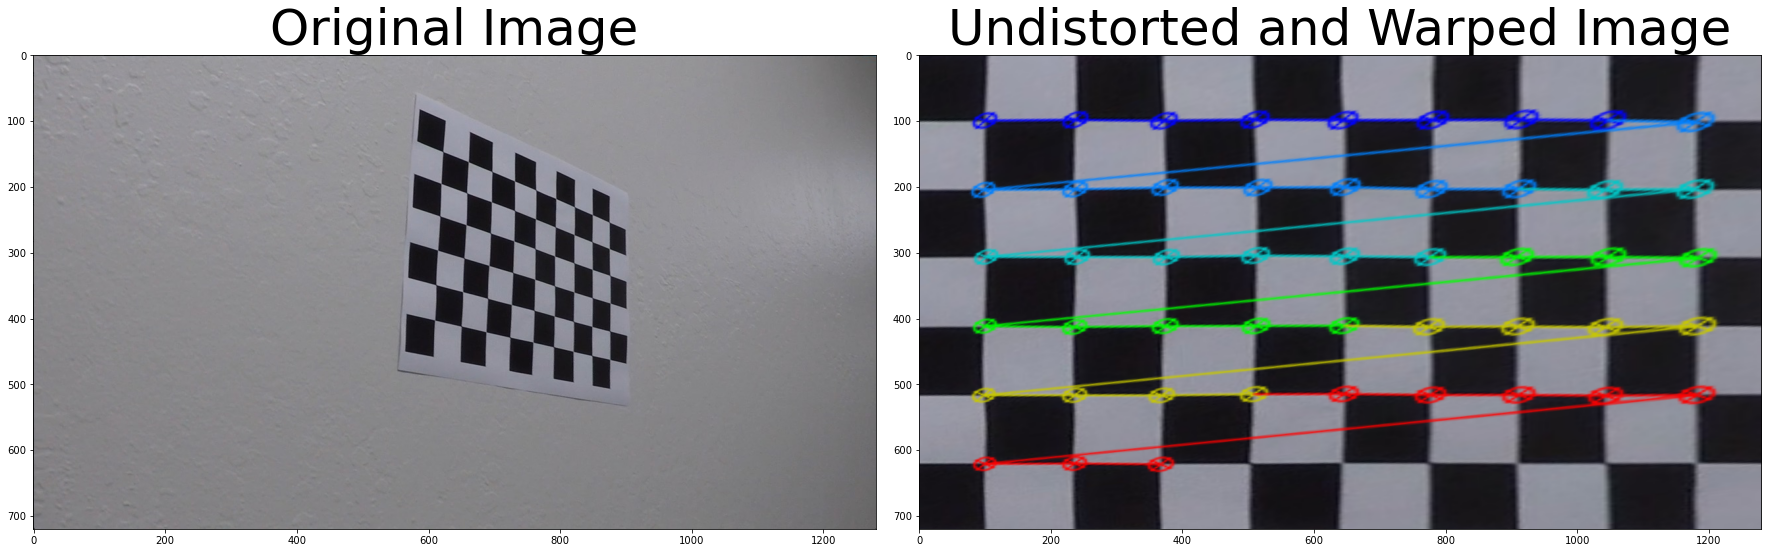

In [4]:
%matplotlib inline 

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=.0, right=1, top=0.9, bottom=0.)

## Color and Gradient Transforms

### Gradient Thresholds

In [5]:
image = mpimg.imread('test_images/straight_lines1.jpg')

In [6]:
# Absolute Sobel Threshold
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Apply sobel depending on orientation
    if orient=='x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        
    # Calculate absolute value of sobel
    abs_sobel = np.absolute(sobel)
    
    # Scale sobel
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Return the binary image
    binary = np.zeros_like(scaled_sobel)
    binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return binary

In [7]:
grad_binary = abs_sobel_thresh(image, orient='x', thresh=(20, 100))

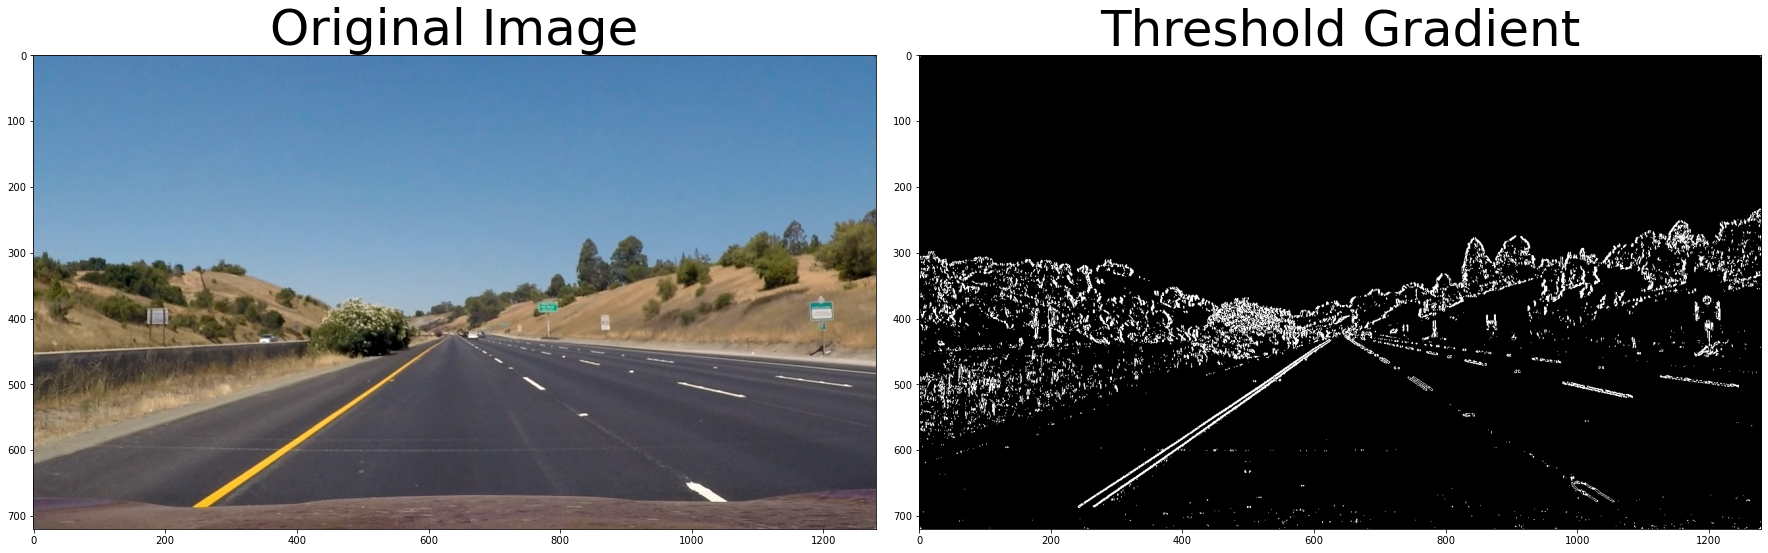

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Threshold Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [9]:
# Magnitude of the Gradient
def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Apply sobel_x and sobel_y
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculate magnitude of gradient
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    # Scale gradmag
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    
    # Return the binary image
    binary = np.zeros_like(gradmag)
    binary[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1
    
    return binary

In [10]:
mag_binary = mag_thresh(image, 5, (30, 100))

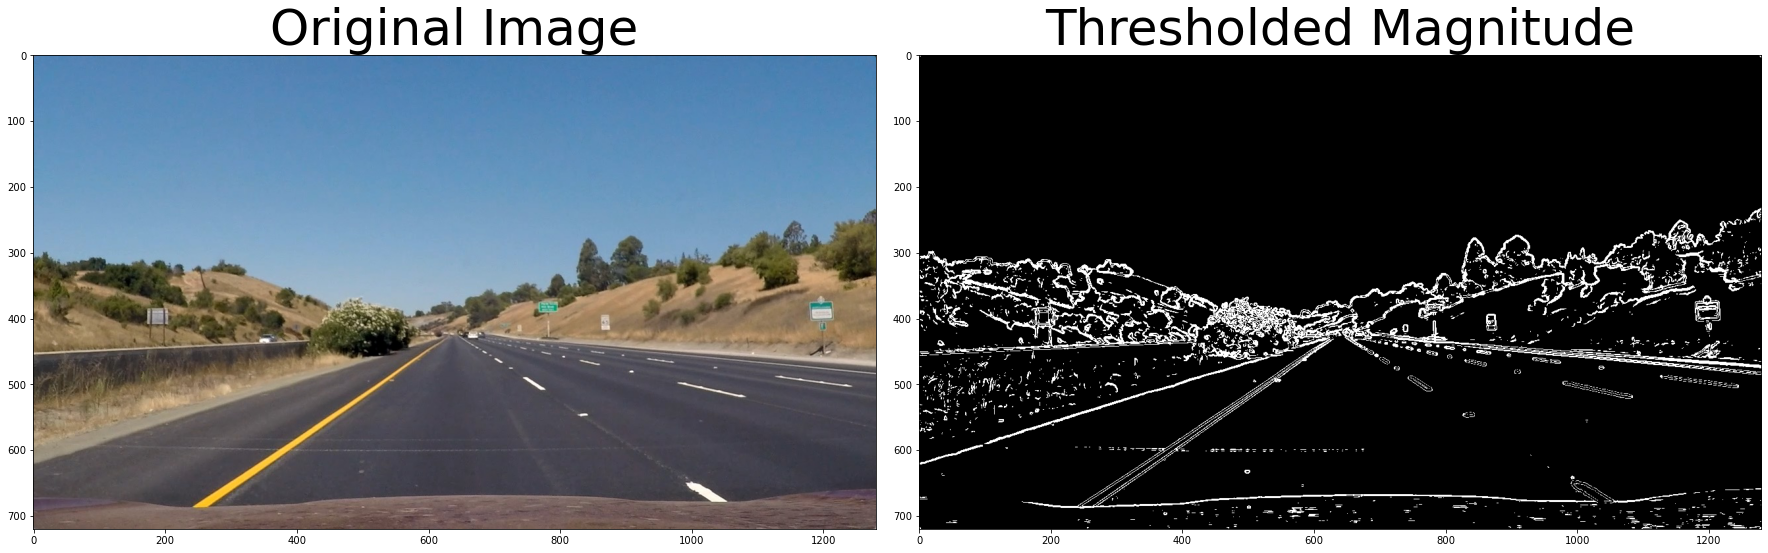

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [12]:
# Direction of the Gradient
def dir_thresh(img, sobel_kernel=3, thresh=(30, 100)):
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Apply sobel_x and sobel_y filters
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculate direction of gradient
    arctan = np.arctan2(np.absolute(sobelx), np.absolute(sobely))
    
    # Return the binary image
    binary = np.zeros_like(arctan)
    binary[(arctan >= thresh[0]) & (arctan <= thresh[1])] = 1
    
    return binary

In [13]:
dir_binary = dir_thresh(image, 5, (0.7, 1.3))

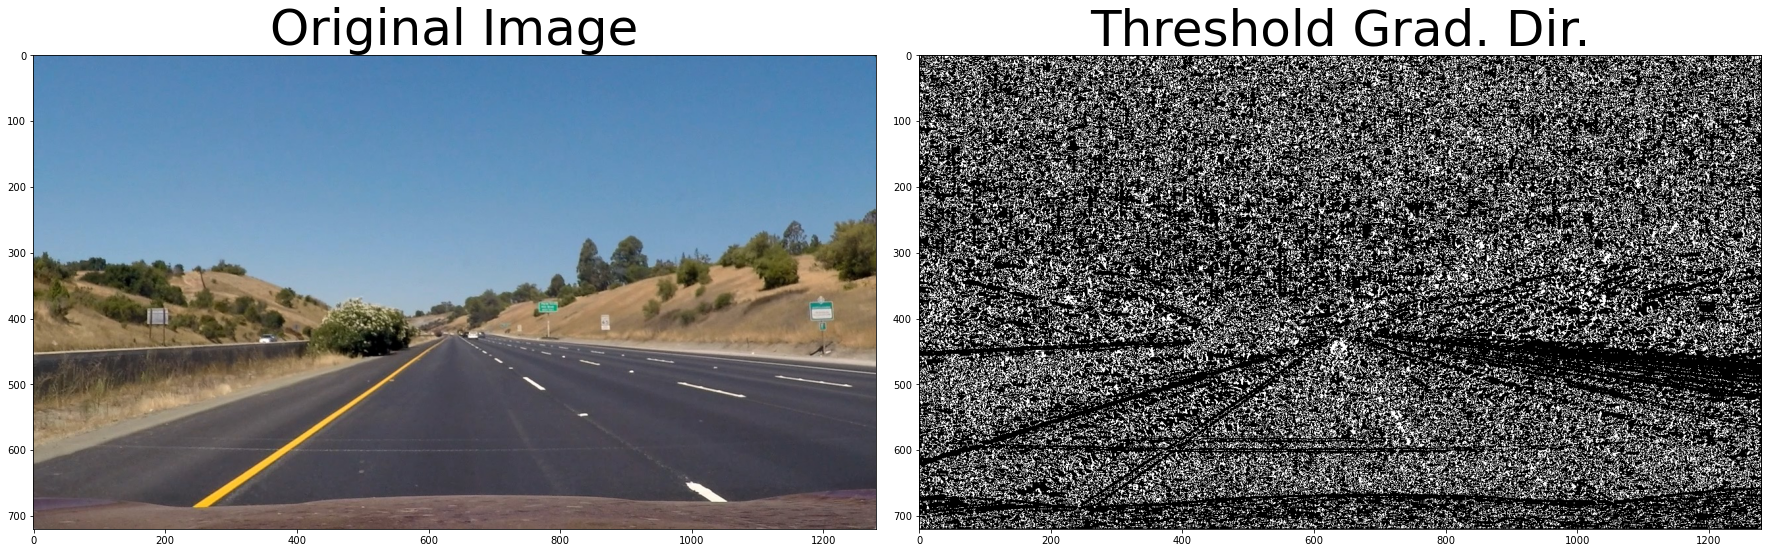

In [14]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Threshold Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [15]:
# Combined Gradient transform

# Sobel kernel size
ksize = 9

gradx = abs_sobel_thresh(image, 'x', ksize, (30, 100))
grady = abs_sobel_thresh(image, 'y', ksize, (30, 100))
mag_binary = mag_thresh(image, ksize, (30, 100))
dir_binary = dir_thresh(image, ksize, (0,7, 1,3))

In [16]:
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

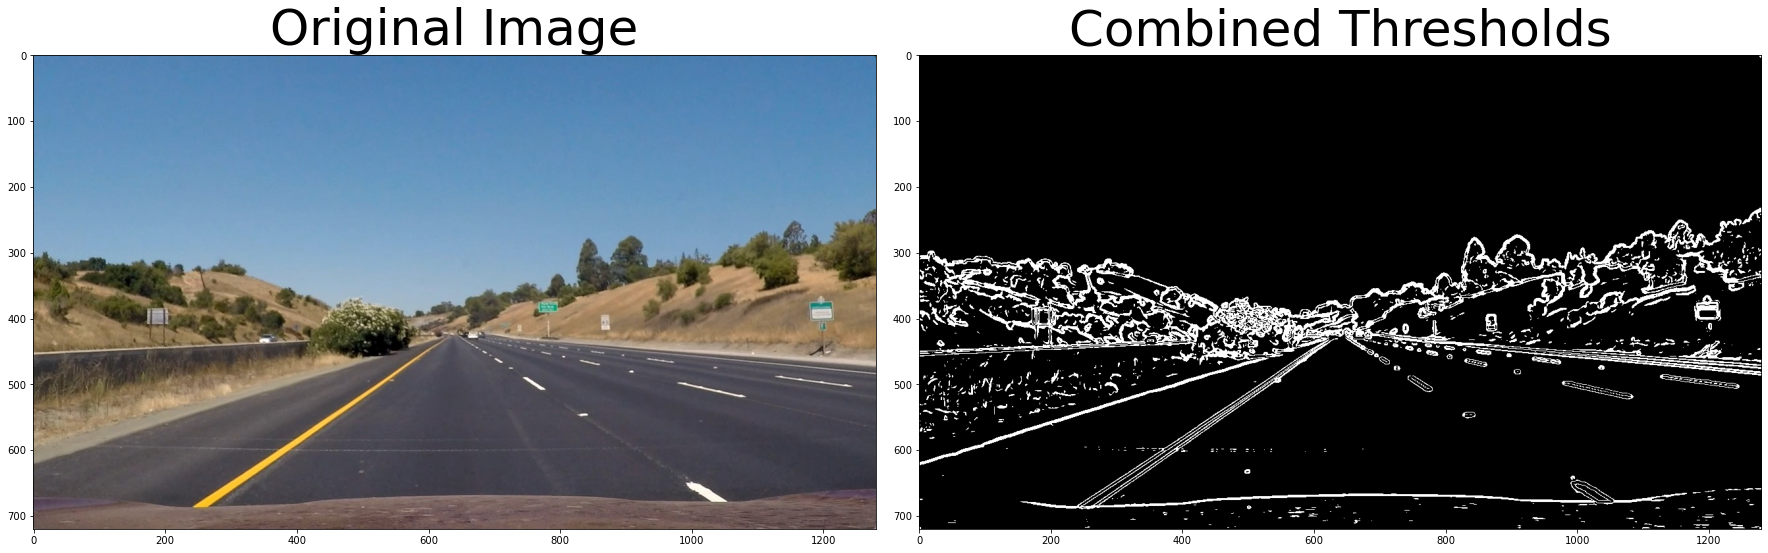

In [17]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Combined Thresholds', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Color Thresholds (S Channel)

In [18]:
def hls_select(img, thresh=(0, 255)):
    
    # Covnert to HLS
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    # Select S channel
    s = hls[:, :, 2]
    
    # Return binary image
    binary = np.zeros_like(s)
    binary[(s >= thresh[0]) & (s <= thresh[1])] = 1
    
    return binary

In [56]:
hls_binary = hls_select(image, thresh=(90, 255))

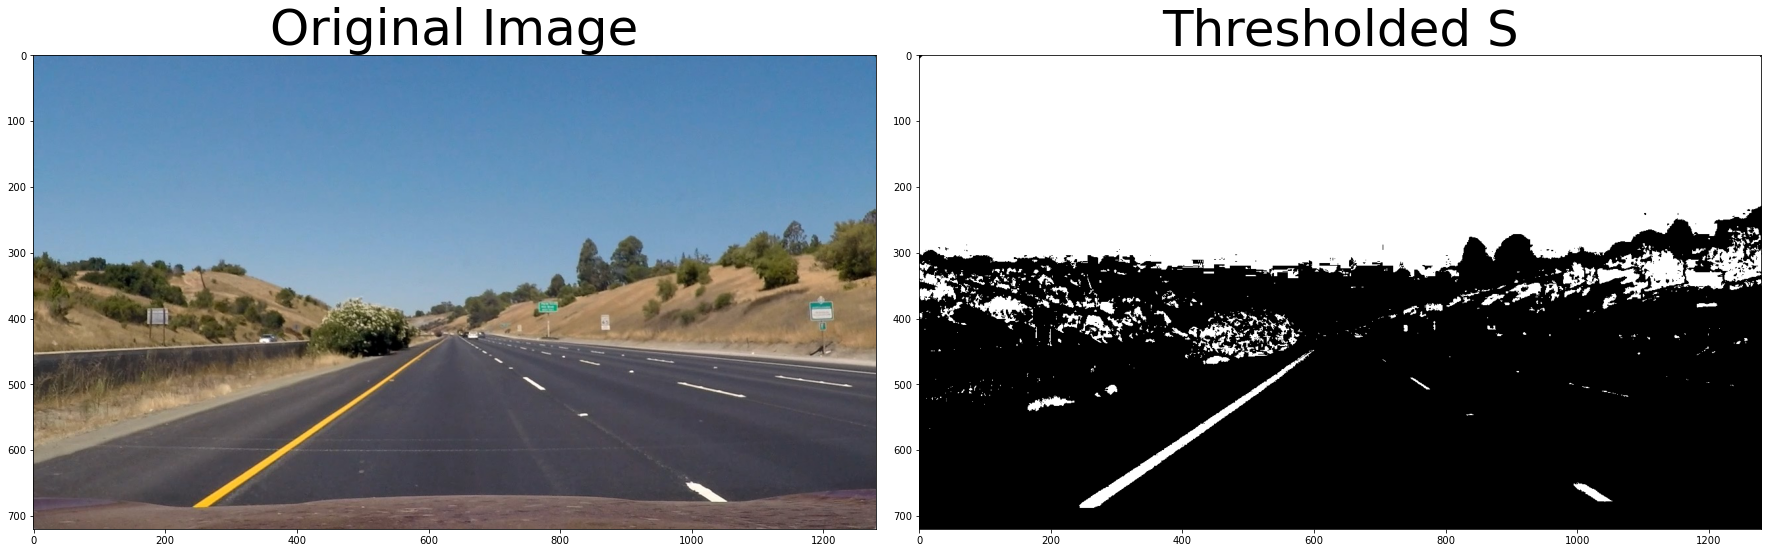

In [20]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(hls_binary, cmap='gray')
ax2.set_title('Thresholded S', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Combining Color and Gradient Thresholds

In [21]:
def combined_thresholds(img, s_thresh=(170, 255), sx_thresh=(30, 100)):
    
    # Copy image
    img = np.copy(img)
    
    # Convert to hls
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    # Seperate l and s channels
    l_channel = hls[:, :, 1]
    s_channel = hls[:, :, 2]
    
    # Apply gradient threshold
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    sx_binary = np.zeros_like(scaled_sobelx)
    sx_binary[(scaled_sobelx >= sx_thresh[0]) & (scaled_sobelx <= sx_thresh[1])] = 1
    
    # Apply color threshold
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Combine color and gradient thresholds
    color_binary = np.dstack((np.zeros_like(sx_binary), sx_binary, s_binary)) * 255
    
    return color_binary

In [22]:
result = combined_thresholds(image)

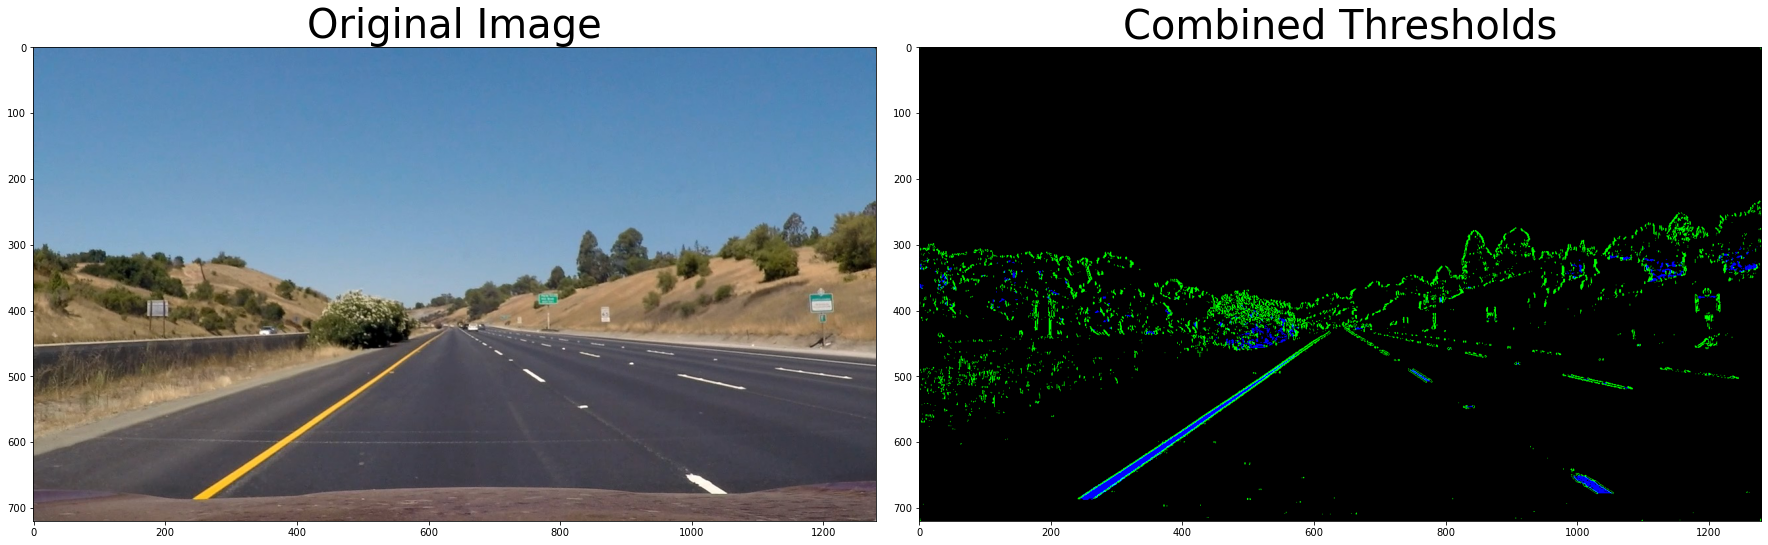

In [23]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(result)
ax2.set_title('Combined Thresholds', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Perspective Transform 

In [77]:
%matplotlib qt

image = mpimg.imread('test_images/test6.jpg')

plt.imshow(image)

In [78]:
# Perspective transform function
def warp(img):
    
    img_size = (img.shape[1], img.shape[0])
    
    # Four source coordinates
    src = np.float32(
        [[535, 488],
         [245, 690],
         [748, 488],
         [1061, 690]])
    
    # Four destination coordinates
    dst = np.float32(
        [[200, 350],
         [200, 750],
         [1000, 350], 
         [1000, 750]])
    
    # Compute the perspective transform
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Compute the inverse by swapping input parameters
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Create warped image
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped

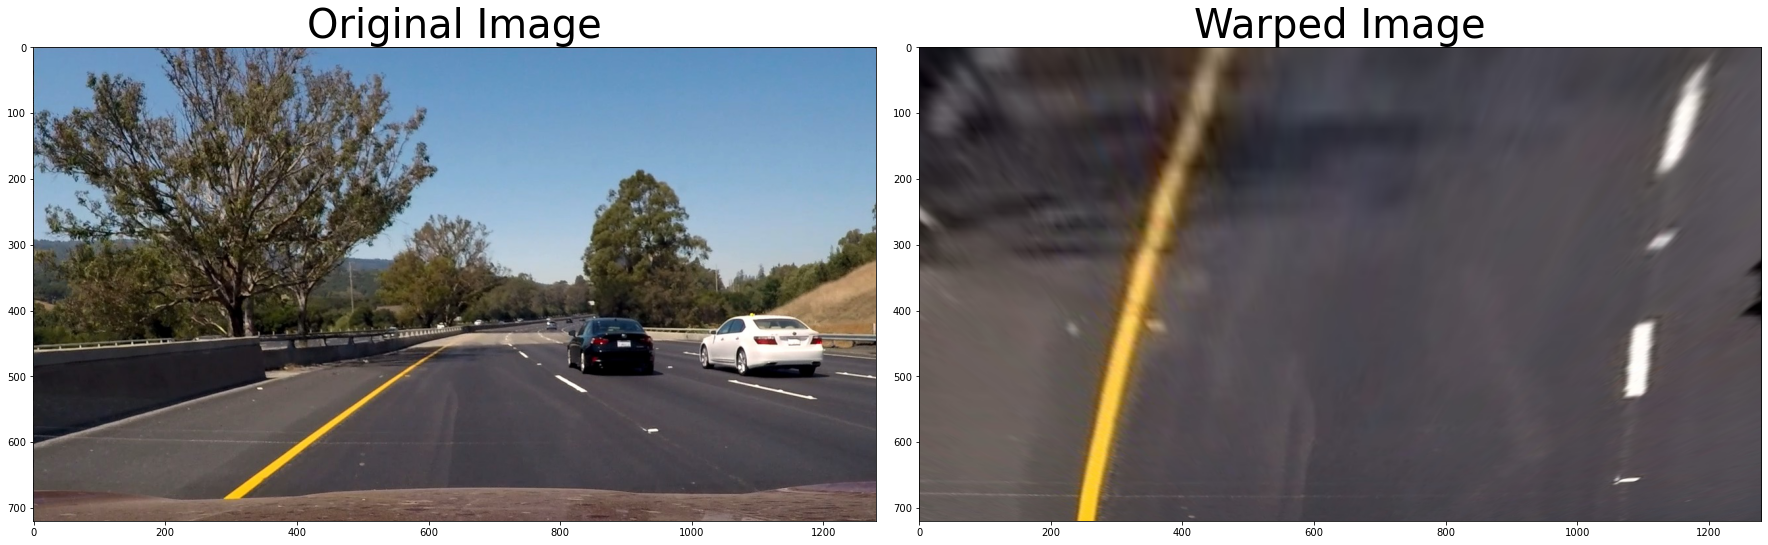

In [79]:
%matplotlib inline

warped = warp(image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(warped)
ax2.set_title('Warped Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Applying color and gradient transforms on warped image

In [86]:
hls_binary_warped = hls_select(warped, thresh=(90, 255))

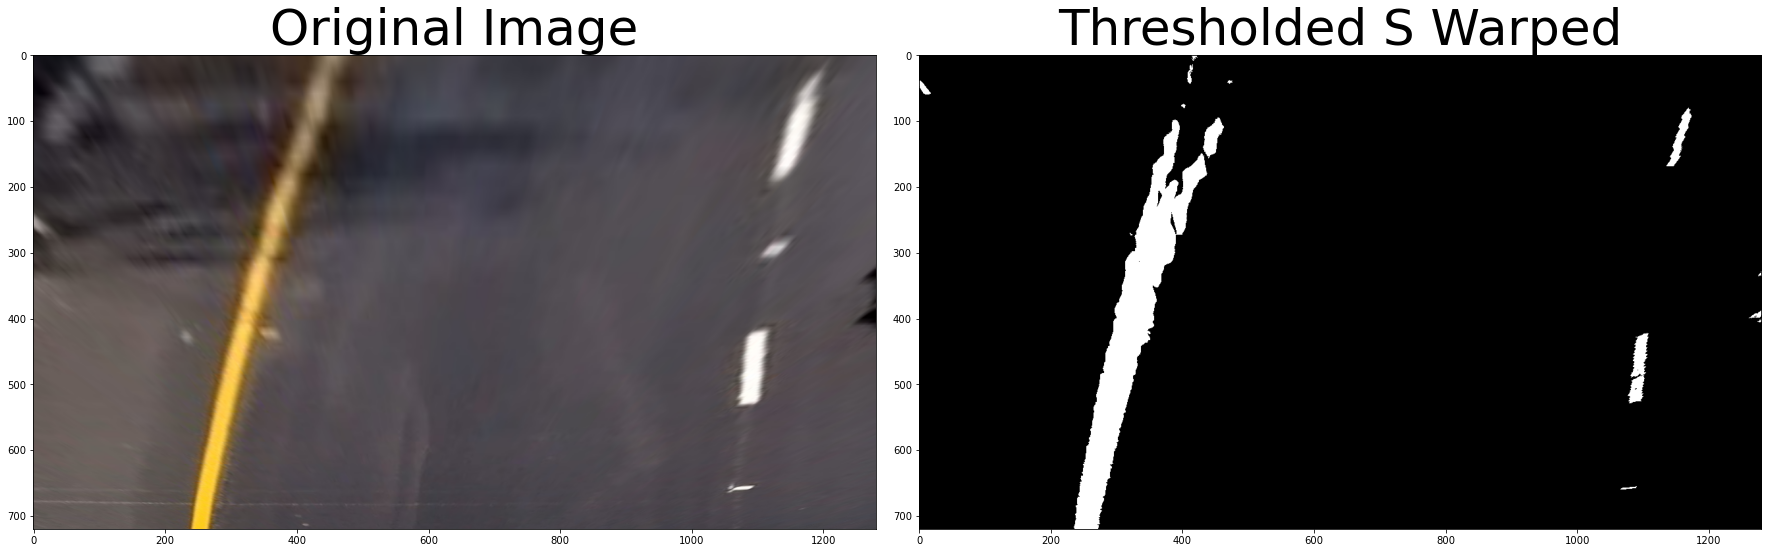

In [87]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(warped)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(hls_binary_warped, cmap='gray')
ax2.set_title('Thresholded S Warped', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [88]:
warped_thresh = combined_thresholds(warped, s_thresh=(200, 255), sx_thresh=(35, 100))

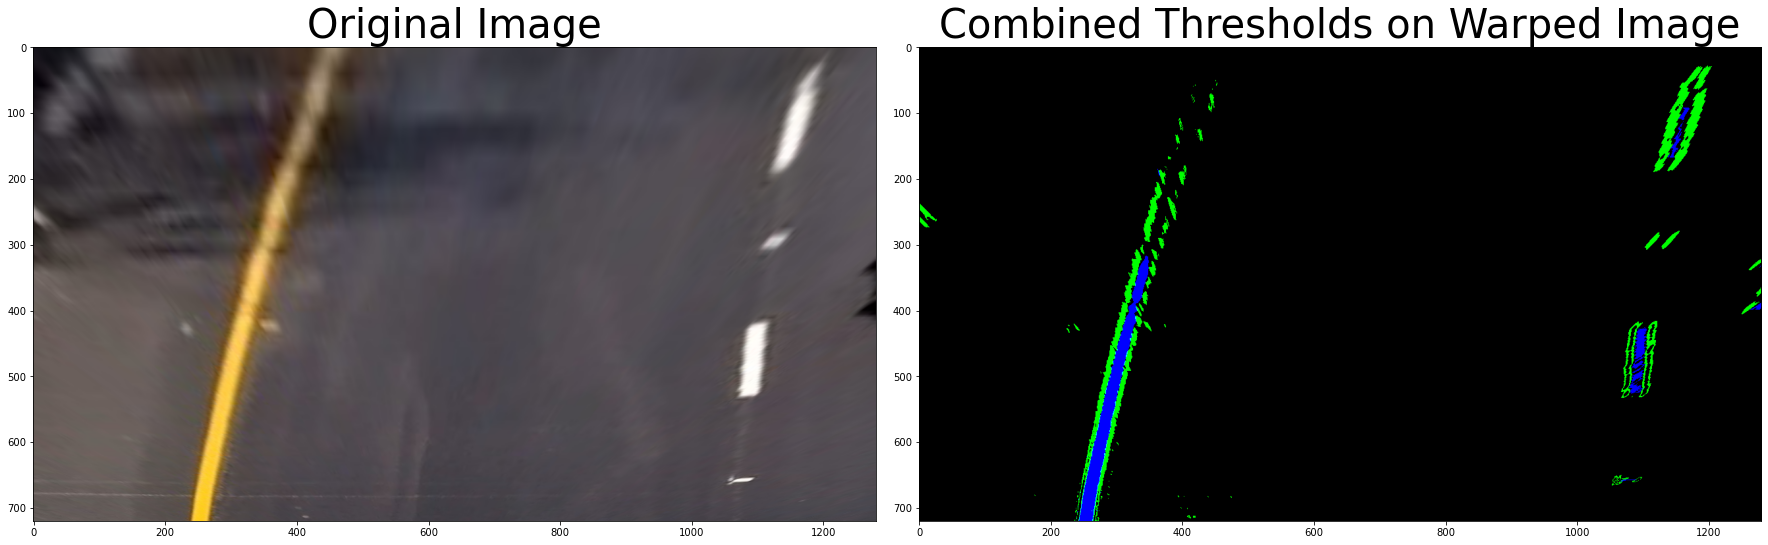

In [89]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(warped)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(warped_thresh)
ax2.set_title('Combined Thresholds on Warped Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Lane Boundary

### Histogram Peaks

In [93]:
# Plot histogram for the lower half of the warped image
def hist(img):
    
    bottom_half = img[img.shape[0]//2:, :]
    
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

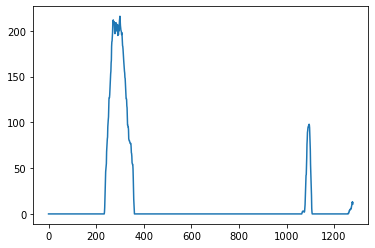

In [97]:
histogram = hist(hls_binary_warped)

plt.plot(histogram)

### Sliding Windows

In [111]:
def find_lane_pixels(img):
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((img, img, img))
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Number of sliding windows
    nwindows = 9
    # Wwidth of the windows +/- margin
    margin = 100
    # Minimum number of pixels found to recenter window
    minpix = 50

    # Height of windows - based on nwindows above and image shape
    window_height = np.int(img.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If > minpix pixels found, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

In [188]:
def fit_polynomial(img):
    
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(img)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left_fit` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    print(left_fit, right_fit)
    
    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    return out_img, ploty

[ 1.49243770e-04 -3.94097093e-01  4.58251801e+02] [ 1.95357673e-04 -2.97509000e-01  1.18949116e+03]


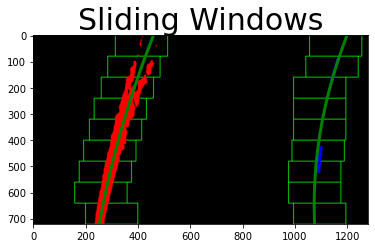

In [216]:
out_img, ploty = fit_polynomial(hls_binary_warped)

# Plot the left and right polynomials on the lane lines    
plt.imshow(out_img)
plt.title('Sliding Windows', fontsize=30)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)

### Search from Prior

In [147]:
left_fit = np.array([2.23090058e-04, -3.90812851e-01, 4.78139852e+02])
right_fit = np.array([4.19709859e-04, -4.79568379e-01, 1.11522544e+03])

In [148]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    
    # Fit a second order polynomial to each with np.polyfit()
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    # Calc both polynomials using ploty, left_fit and right_fit
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

In [182]:
def search_around_poly(img):
    
    # HYPERPARAMETERS
    # Width of the margin around the previous polynomial to search
    margin = 100
    
    # Activated pixels
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Area of search based on activated x-values within the +/- margin of our polynomial function
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) &
                      (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) &
                       (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(img.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((img, img, img))
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    return result, left_fitx, right_fitx

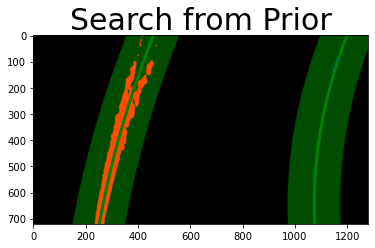

In [214]:
result, leftx, rightx = search_around_poly(hls_binary_warped)

# Plot the polynomial lines onto the image
plt.imshow(result)
plt.title('Search from Prior', fontsize=30)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)

## Lane Curvature in Pixels

In [194]:
# Conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # metrers per pixel in x dimension

In [209]:
# Measure curvature of lines in meters
def measure_curvature(img, leftx, rightx):
    
    ploty = np.linspace(0, img.shape[0] - 1, img.shape[0])
    
    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y
    
    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

In [210]:
# Calculate the radius of curvature for both lane lines
left_curverad, right_curverad = measure_curvature(hls_binary_warped, leftx, rightx)

print('Left line curvature:', left_curverad, 'm')
print('Right line curvature:', right_curverad, 'm')

Left line curvature: 1104.5205756629712 m
Right line curvature: 551.1178800955811 m


## Offset of the Car from Center

In [211]:
# Measure offset of the car from the center
def offset(img, leftx, rightx):
    
    # Horizontal mid point of the image
    img_midx = img.shape[1]/2
    
    # Position of the car w.r.t. the lane
    position = (leftx[-1] + rightx[-1])/2
    
    # Horizontal car offset
    offset = (img_midx - position) * xm_per_pix
    
    return offset

In [212]:
offset = offset(hls_binary_warped, leftx, rightx)

print ('Car offset from center:', offset, 'm')

Car offset from center: -0.12403914718412673 m
